# This script carries out ordinal archetypal analysis using a two step procedure. 
### The method was proposed by et. al. Epifanio in "Archetypal Analysis for Ordinal Data"


## Importing dependencies

In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim

from scipy.special import softmax

from CAA_class import _CAA

# Load the dataset and remove the nominal columns

In [42]:
df = pd.read_csv('ESS8_data.csv')
attributeNames = df.columns

X = df.drop(['ID', 'Country', 'left_right', 'immigrants', 'homosexual',
       'Satisfy_life', 'Satisfy_health', 'Attitude2EU', 'gender', 'age',
       'education', 'subjective_income', 'TR_CFA', 'CO_CFA', 'SC_CFA',
       'HD_CFA', 'ST_CFA', 'SD_CFA', 'PO_CFA', 'AC_CFA', 'UN_CFA', 'BE_CFA',
       'SBM8', 'SBM9', 'SBM16', 'LCA5', 'LCA8', 'LCA16'], axis = 1).to_numpy()

N, M = X.shape

#print(N, M)

### Calculate the $\theta $ values. 
### Replace observations in X with the corresponding $\theta_i$
### Apply conventional AA.

In [1]:
class _TSAA:
    
    RSS = []    
    
    
    def _logOdds(self, X):
        Ordinals = range(min(self.X.flatten()), max(self.X.flatten()+1))
    
        probs = [(np.count_nonzero(self.X.flatten() == e))/len(self.X.flatten()) for e in Ordinals]
        baseline = max(probs)
    
        logvals = [np.log(probs[i]/baseline) for i in range(len(probs))]
        return logvals
    
    def _applySoftmax(self,M):
        return softmax(M)
    
    
    def _projectOrdinals(self, X):
        M, N = X.shape
        
        X_thilde = np.empty((M, N))
        
        theta = self._applySoftmax(self._logOdds(X))
        Ordinals = range(min(self.X.flatten()), max(self.X.flatten()+1))
        for i in range(M):
            for j in range(N):
                idx = X[i,j]-1
                X_thilde[i,j] = theta[idx]
                
        return X_thilde

    
    def _error(self, X,B,A):
        return torch.norm(X - X@B@A, p='fro')**2
    
    def _apply_constraints(self, A):
        m = nn.Softmax(dim=0)
        return m(A)
    
    
    ############# Two-step ordinal AA #############
    def _compute_archetypes(self, X, K, n_iter, lr, mute,columns):
        
        ##### Project the data #####
        X_thilde = self._projectOrdinals(X)
        
        
        ##### Now conventional AA is applied #####
        self.RSS = []
        start = timer()
        if not mute:
            loading_bar = _loading_bar(n_iter, "Conventional Arhcetypal Analysis")
        N, _ = X.T.shape
        Xt = torch.tensor(X,requires_grad=False).float()
        A = torch.autograd.Variable(torch.rand(K, N), requires_grad=True)
        B = torch.autograd.Variable(torch.rand(N, K), requires_grad=True)
        optimizer = optim.Adam([A, B], amsgrad = True, lr = 0.01)


        for i in range(n_iter):
            if not mute:
                loading_bar._update()
            optimizer.zero_grad()
            L = self._error(Xt, self._apply_constraints(B), self._apply_constraints(A))
            self.RSS.append(L.detach().numpy())
            L.backward()
            optimizer.step()

        A_f = self._apply_constraints(A).detach().numpy()
        B_f = self._apply_constraints(B).detach().numpy()
        Z_f = (Xt@self._apply_constraints(B)).detach().numpy()
        X_hat_f = X@B_f@A_f
        end = timer()
        time = round(end-start,2)
    
        ########## POST ANALYSIS ##########
        A_f = self._apply_constraints(A).detach().numpy()
        B_f = self._apply_constraints(B).detach().numpy()
        Z_f = (Xt@self._apply_constraints(B)).detach().numpy()
        X_hat_f = X@B_f@A_f
        end = timer()
        time = round(end-start,2)
        
        
        result = _CAA_result(A_f, B_f, X, X_hat_f, n_iter, self.RSS, Z_f, K, time,columns,"CAA")
        
        
        if not mute:
            result._print()

        return result
        
        
        
        
    
    
        
    
        
            
        
        
        
        
        
        

## Instance of the class 

In [47]:
two_step_AA = _TSAA(X)
X_thilde = two_step_AA._projectOrdinals()

In [48]:
result = two_step_AA.applyAA(X=X_thilde.T, K=5, n_iter=1000, lr=0.01, mute=False,columns=None)


Conventional Arhcetypal Analysis in progress...
Finished Successfully after 16.3 seconds!                               

/////////////// INFORMATION ABOUT CONVENTIONAL ARCHETYPAL ANALYSIS \\\\\\\\\\\\\\\\
▣ The Conventional Archetypal Analysis was computed using 5 archetypes.
▣ The Conventional Archetypal Analysis was computed on 21 attributes.
▣ The Conventional Archetypal Analysis was computed on 41293 subjects.
▣ The Conventional Archetypal Analysis ran for 1000 itterations.
▣ The Conventional Archetypal Analysis took 16.34 seconds to complete.
▣ The final RSS was: 3286.5166015625.


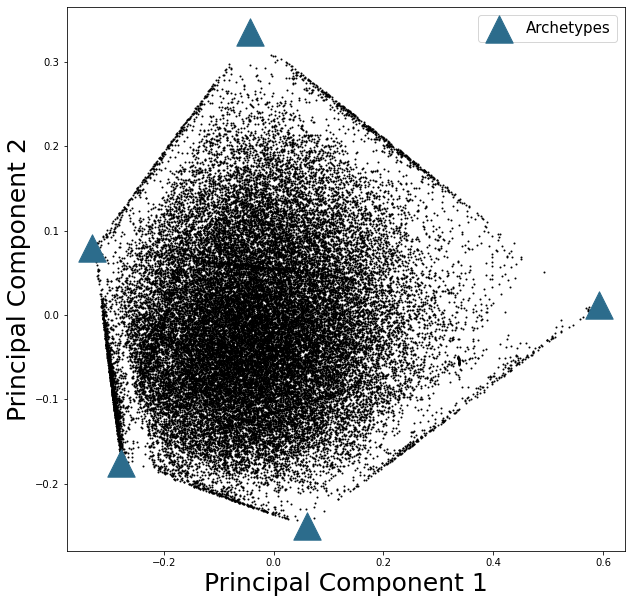

In [49]:
result._plot(plot_type="PCA_scatter_plot", attributes=[0,1], archetype_number=0, types={}, weighted="equal_norm")
